In [9]:
import numpy as np
import pandas as pd

# Happiness inside a job: a social network analysis

# TODOS:

- Select target happyness.
- Evaluate regressors.
- Upload graph feature extraction.
- Plots Notebook.

## Index

1. [Structure of the database](#1.-Structure-of-the-database)

# 1. Structure of the database

## 1.1 What is Happyforce

During these examples we will be dealing with a database provided by **[Happyforce](http://www.myhappyforce.com/es/#four-steps)**.  It contains anonimized information about the votes, comments and interactions among the different users of the application. #TODO: detailed introduction.

TODO: expain how the app work +images

## 1.2 Happyness votes data

The data regarding the votes of the app users is stored in **votes.csv**. This file containg 4 different columns:

- **employee**: An integer id that identifies an amployee inside a company.
- **companyAlias**: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
- **voteDate**: String representing the date a given vote was emited.
- **vote**: The numeric value of the vote emited ranging from 1 to 4.

In [23]:
votes = pd.read_csv('data/votes.csv',parse_dates=[2]).drop_duplicates()
votes.head(3)

,employee,companyAlias,voteDate,vote
0,31,56aec740f1ef260003e307d6,2016-02-01,4
1,33,56aec740f1ef260003e307d6,2016-02-01,4
2,79,56aec740f1ef260003e307d6,2016-02-01,4


## 1.3 Comments data

It is possible to find data about the comments written in the app in the **anon_comments.csv** file, and it has the following structure:

- **employee**: An integer id that identifies an amployee inside a company.
- **companyAlias**: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
- **commentDate**: String representing the date a given comment was written.
- **commentId**: A unique id for a given comment.
- **comment**: Anonimized comment. It has the same length as the original comment. 
- **likes**: Number of likes that the comment received.
- **dislikes**: Number of dislikes that the comment received.

In [22]:
comments = comments = pd.read_csv('data/anon_comments.csv',parse_dates=[-1]).drop('Unnamed: 0',axis=1)
comments.head(3)

,employee,companyAlias,commentId,comment,likes,dislikes,commentDate
0,307,56aec740f1ef260003e307d6,58d018d7e010990004e38070,**********************************************...,4.0,0.0,2017-03-20 18:00:17
1,382,56aec740f1ef260003e307d6,58d0179ae010990004e3806d,*****************************,1.0,2.0,2017-03-20 17:55:16
2,172,56aec740f1ef260003e307d6,58cff8cde010990004e37f6a,***************************,3.0,0.0,2017-03-20 15:44:02


## 1.3 Employee Interactions

The file **commentInteractions.csv** contains information about which employee liked or disliked a given comment.

- **employee**: An integer id that identifies an amployee inside a company.
- **companyAlias**: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
- **commentId**: A unique id for a given comment that allows us to relate it with the comments in anon_comments.csv.

- **liked**: A boolean that is True if the employee liked the comment.
- **disliked**: A boolean that is True if the employee disliked the comment.

In [8]:
inters = pd.read_csv('data/commentInteractions.csv').dropna(how='any').drop_duplicates()
inters.head(3)

/home/kalidus/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,employee,companyAlias,liked,disliked,commentId
0,307,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
1,36,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
2,276,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070


## 1.4 Last participation date of employees

The **lastParticipationExists.csv** file contains information about the date of the last interaction of an employee with the app.

- **employee**: An integer id that identifies an amployee inside a company.
- **companyAlias**: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
- **numVotes**: Total number of happyness votes emited by the user.
- **lastParticipationDate**: Date of the last interaction of the user with the app.
- **stillExists**: Boolean that is True if the user is still registered in the app.

In [29]:
lastpart = pd.read_csv('data/lastParticipationExists.csv',parse_dates=[3]).drop_duplicates()
lastpart.head(3)

,employee,companyAlias,numVotes,lastParticipationDate,stillExists
0,512,56aec740f1ef260003e307d6,4,2017-02-23 11:48:04,True
1,-2,56aec740f1ef260003e307d6,0,2017-01-18 13:00:55,False
2,2,56aec740f1ef260003e307d6,72,2017-03-17 00:00:00,True


# 2. Data cleaning process

We would like to use this data to predict the future happyness of an employee base on its past interactions with the app. In order to get a suitable dataset for this task we will follow the following process:

1. **Select an arbitrary prediction date.** <p>
    Only data prior to 26 Dec 2016 will be used to build our training and evaluation datasets.<p>
2. **Use only data belonging non churned employees**.<p>
    All the employees that churned before the prediction date will be removed from the training and test set. <p>
3. **Use only data belonging to active employees**.<p>
    We will only take into account employees that voted at least 5 times before the predictions date and 2 times after the prediction date and before the data collection period ended.  <p>
5. **Employees with more than 5 likes/dislikes**.<p>
    We will only take into account employees that liked or disliked a comment at least 5 times during the observation period.  <p>
    
5. **Creating a target variable**.<p>
    The target variable for this use case will be a binary variable that relates to the happyness level of an employee. If the mean of the votes emited by an employee is greater than 2, the target variable will be 1, otherwise it will be 0.  <p>

## 2.1 Filtering by an arbitrary prediction date

In order to filter the data set by dates and remove the unwanted employees we need calculate the first date an employee interacted with the app. 

In [61]:
#get first dates on different DataFrames
min_date_comment = pd.DataFrame(comments.groupby(['companyAlias','employee'])['commentDate'].apply(np.min))
min_date_votes = pd.DataFrame(votes.groupby(['companyAlias','employee'])['voteDate'].apply(np.min))
min_date_part = pd.DataFrame(lastpart.groupby(['companyAlias','employee'])['lastParticipationDate'].min())
#combine them
min_dates = pd.merge(min_date_comment,min_date_votes,right_index=True,left_index=True,how='outer')
min_dates = pd.merge(min_dates,min_date_part,right_index=True,left_index=True,how='outer')
#take the earliest date of the 3 different DataFrames and propagate nans employee wise
first_dates = pd.DataFrame(min_dates.fillna(method='ffill',axis=1).fillna(method='bfill',axis=1).min(axis=1),
                           columns=['first_date'])
first_dates.head(3)

first_date
companyAlias             employee                    
5370af43e4b0cff95558c12a -117     2016-03-04 09:55:34
                         -116     2016-09-12 11:53:45
                         -115     2016-09-12 11:54:00

Now we create a DataFrame containing the first date of app usage, the last date an employee used the app, and  a column that indicates if the user is still registered in the app. Now we can filter employees by periods of activity.

In [62]:
last_dates = lastpart.set_index(['companyAlias','employee'])[['lastParticipationDate','stillExists']].copy()
dates = pd.merge(first_dates,last_dates,right_index=True,left_index=True,how='outer')
dates.ix[-5:-1].head()

first_date lastParticipationDate stillExists
companyAlias             employee                                             
58c6e15f32f72a00046f556c 58       2017-03-14   2017-03-14 23:13:43        True
                         59       2017-03-14   2017-03-14 23:13:43        True
                         60       2017-03-14   2017-03-20 14:29:20        True
                         61       2017-03-14   2017-03-14 23:13:43        True

## 2.2 Filtrering employees

- We delete employees churned before 16 Feb 2017 (data collection ended).
- We delete employees that started using the app after 1 feb 2017(prediction date).



In [63]:
prediction_date = '6 Feb 2017'
data_collection_ended = '19 Feb 2017'

In [69]:
c_first = dates['first_date']<=pd.to_datetime(prediction_date)
c_last = dates['lastParticipationDate']>pd.to_datetime(data_collection_ended)
users_index = dates[c_first&c_last].copy()

In [70]:
len(users_index.reset_index()['companyAlias'].unique()),len(users_index.index)

(21, 1694)

This means that we will be dealing with 1710 employees across 21 different companies. You can see in the following plot the number of employees of every company. 

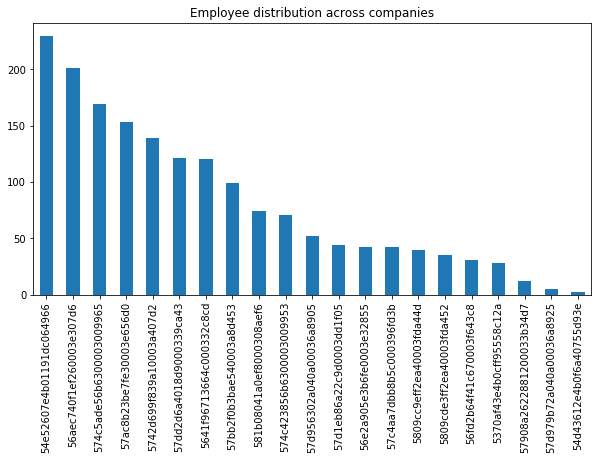

In [57]:
%matplotlib inline
users_index.reset_index()['companyAlias'].value_counts().plot(kind='bar',
                                                              figsize=(10,5),
                                                              title='Employee distribution across companies')

## 2.2 Calculating the target variable

We will try to predict the future hapiness of an employee. We will model the future happiness as a binary variable that will be 1 if the mean vote score of an employee the next two weeks after the prediction date is greater than 2, and 0 otherwise.

In [59]:
c_first = votes['voteDate']>pd.to_datetime(prediction_date)
c_last = dates['lastParticipationDate']>pd.to_datetime(data_collection_ended)
users_index = dates[c_first&c_last].copy()

,employee,companyAlias,voteDate,vote
0,31,56aec740f1ef260003e307d6,2016-02-01,4
1,33,56aec740f1ef260003e307d6,2016-02-01,4
2,79,56aec740f1ef260003e307d6,2016-02-01,4
3,94,56aec740f1ef260003e307d6,2016-02-01,4
4,16,56aec740f1ef260003e307d6,2016-02-01,2
5,20,56aec740f1ef260003e307d6,2016-02-01,2
6,22,56aec740f1ef260003e307d6,2016-02-01,2
7,41,56aec740f1ef260003e307d6,2016-02-01,2
8,83,56aec740f1ef260003e307d6,2016-02-01,2
9,12,56aec740f1ef260003e307d6,2016-02-01,3


# 1. Employee features

The are the features that realte to absolute employee metrics. 

## 2.1 vote features

In [6]:

vote_feats = votes.groupby(['uid'])['vote'].agg({'votes_1': lambda x: len(x[x==1]),
                                                        'votes_2': lambda x: len(x[x==2]),
                                                        'votes_3': lambda x: len(x[x==3]),
                                                        'votes_4': lambda x: len(x[x==4]),
                                                        'votes_mean': lambda x: x.mean(),
                                                        'votes_std': lambda x: x.std(),
                                                       'votes_num': lambda x: len(x),
                                                       }).copy().fillna(0)

## 2.2 Comments features

In [7]:
likes_feats = comments.groupby(['uid'])['likes'].agg({
                                          'likes_mean': lambda x: len(x),
                                          'likes_std': lambda x: x.std(),
                                          'likes_sum': lambda x: x.sum(),
                                                       })
dislikes_feats = comments.groupby(['uid'])['dislikes'].agg({
                                          'dislikes_mean': lambda x: len(x),
                                          'dislikes_std': lambda x: x.std(),
                                          'dislikes_sum': lambda x: x.sum(),
                                                       })
coms_feats = comments.dropna().groupby(['uid'])['comment'].agg({'com_num': lambda x: len(x),
                                                             'com_mean': lambda x: x.apply(len).mean(),
                                                             'com_std': lambda x: x.map(len).std(),
                                                             'com_sum': lambda x: x.map(len).sum()})

## 2.3 Merge all the features

In [8]:
features = pd.merge(vote_feats,likes_feats,left_index=True,right_index=True,how='outer')
features = pd.merge(features,dislikes_feats,left_index=True,right_index=True,how='outer')
features = pd.merge(features,coms_feats,left_index=True,right_index=True,how='outer')
features = pd.merge(features,users_index.set_index('uid')[['churn','comp_short']],left_index=True,right_index=True,how='left').fillna(0)#fill users with 0 comments
features.rename(columns={'comp_short':'comid'},inplace=True)
E_features = features.copy()
E_features.rename(columns=dict([(x,'E_'+str(x)) for x in E_features.columns]),inplace=True)
